In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
def plot_2d_contour(az_grid, el_grid, z, levels=10, cmap='viridis', title='2D Contour Plot'):
    """
    Create a 2D contour plot.
    """
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(az_grid, el_grid, z, levels=levels, cmap=cmap)
    plt.colorbar(contour)
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.show()

def calc_projected_weights(steering_mat, resp_vec):
    """
    Calculate projection-based weights enforcing exact response.
    """
    m, n = steering_mat.shape
    S = steering_mat.T


    if m < n:  # Wide (fat)
        w = S @ np.linalg.inv(S.conj().T @ S) @ resp_vec
    elif m == n:  # Square

        w = np.linalg.inv(S.conj()) @ resp_vec
    else:  # Tall (thin)

        w = np.linalg.inv(steering_mat.conj().T @ steering_mat) @ steering_mat.conj().T @ resp_vec

    return w

def calc_2d_plot_grid(az_min, az_max, num_points_az, el_min, el_max, num_points_el):
    """
    Create a grid of points for plotting.
    """
    x = np.linspace(az_min, az_max, num_points_az)
    y = np.linspace(el_min, el_max, num_points_el)
    az_grid, el_grid = np.meshgrid(x, y)
    return az_grid, el_grid

def calc_steering_mat(aoa_azimuth_vec, aoa_elevation_vec, wavelength_vec, array_length, array_width, element_spacing):
    """
    Calculate the steering vector for a given frequency and array geometry.
    """
    angle_matrix = np.concatenate((aoa_elevation_vec[None, :], aoa_azimuth_vec[None, :]), axis=0)
    angle_matrix = np.radians(angle_matrix)
    print('angle_matrix:',angle_matrix)
    k = (2 * np.pi) / 0.29979 #assumes freq of array is 1 GHz

    kx = k * np.cos(angle_matrix[0]) * np.cos(angle_matrix[1])
    ky = k * np.cos(angle_matrix[0]) * np.sin(angle_matrix[1])
    kz = k * np.sin(angle_matrix[0])

    steering_vector_kx = np.exp(-1j * (kx[:, np.newaxis] * np.arange(array_length) * element_spacing))[:, np.newaxis, :]
    steering_vector_kz = np.exp(-1j * (kz[:, np.newaxis] * np.arange(array_width) * element_spacing))[:, :, np.newaxis]
    steering_mat = steering_vector_kx * steering_vector_kz
    steering_mat = steering_mat.reshape(steering_mat.shape[0], -1)
    return steering_mat

def calc_2d_array_factor(frequency_vec, array_length, array_width, element_spacing, az_min, az_max, az_res, el_min, el_max, el_res, calc_weight):
    """
    Calculate the 2D array factor for a given steering matrix and weights.
    """
    az_range_rad = np.radians(np.arange(az_min, az_max, az_res))[None, :]
    el_range_rad = np.radians(np.arange(el_min, el_max, el_res))[:, None]
    k = 2 * np.pi * frequency_vec / 3e8
    kx = k[0] * np.cos(el_range_rad) * np.cos(az_range_rad)
    ky = k[0] * np.cos(el_range_rad) * np.sin(az_range_rad)
    kz = k[0] * np.sin(el_range_rad)
    scan_kx = np.exp(-1j * (kx[:, :, None] * np.arange(array_length) * element_spacing))[:, :, None, :]
    scan_kz = np.exp(-1j * (kz[:, :, None] * np.arange(array_width) * element_spacing))[:, :, :, None]
    scan_overall = scan_kx * scan_kz
    scan_overall = scan_overall.reshape((scan_overall.shape[0], scan_overall.shape[1], -1))
    weight_conj = calc_weight[None, None,:].conj()
    array_factor = np.sum(weight_conj * scan_overall, axis=2)
    # print('array factor:', array_factor.shape)
    return np.abs(array_factor)

def generate_random_scenario(num_constraints,num_elements):
    """
    Generate random angles of arrival and response vector.
    """
    # Randomly generate angles of arrival
    aoa_az_vec = np.random.uniform(-180, 180, num_constraints)
    aoa_el_vec = np.random.uniform(0, 180, num_constraints)

    # Randomly generate response vector
    resp_vec = np.random.randint(0, 2, num_constraints)*num_elements
    # frequency_vec = np.random.uniform(0.9999e9, 1e9, num_constraints)
    frequency_vec = np.ones(num_constraints)*1e9
    lam_vec = 3e8 / frequency_vec

    return aoa_az_vec, aoa_el_vec, resp_vec,frequency_vec,lam_vec
def calc_delay_sum_bf(steering_mat):
    """
    Perform delay-and-sum beamforming.

    """

    weights = steering_mat[0, :].conj().T
    print('weights:', weights.shape)

    return weights

In [3]:
c = 3e8
NUM_CONSTRAINTS = 7
ARRAY_LENGTH = 3
ARRAY_WIDTH = 5
NUM_ELEMENTS = ARRAY_LENGTH * ARRAY_WIDTH

# FREQUENCY_VEC = np.array([1e9, 1.03e9, 1.01e9, 0.99e9])
# LAM_VEC = c / FREQUENCY_VEC
# AOA_AZ_VEC = np.array([0, -10, 20, -35])
# AOA_EL_VEC = np.array([90, 35, 99, 17])
# RESP_VEC = np.array([NUM_ELEMENTS, 0, 0, NUM_ELEMENTS])

AOA_AZ_VEC,AOA_EL_VEC, RESP_VEC,FREQUENCY_VEC,LAM_VEC = generate_random_scenario(NUM_CONSTRAINTS,NUM_ELEMENTS)
ELEM_SPACING = LAM_VEC[0] / 2

STEERING_MAT = calc_steering_mat(AOA_AZ_VEC, AOA_EL_VEC, LAM_VEC, ARRAY_LENGTH, ARRAY_WIDTH, ELEM_SPACING)
PB_BF_WEIGHTS = calc_projected_weights(STEERING_MAT, RESP_VEC)
CONV_BF_WEIGHTS = calc_delay_sum_bf(STEERING_MAT)

AZ_MIN = -180
AZ_MAX = 180
AZ_RES = 1
EL_MIN = 0
EL_MAX = 180
EL_RES = 1

AF_PBBF = calc_2d_array_factor(FREQUENCY_VEC, ARRAY_LENGTH, ARRAY_WIDTH, ELEM_SPACING, AZ_MIN, AZ_MAX, AZ_RES, EL_MIN, EL_MAX, EL_RES, PB_BF_WEIGHTS)
AF_conv = calc_2d_array_factor(FREQUENCY_VEC, ARRAY_LENGTH, ARRAY_WIDTH, ELEM_SPACING, AZ_MIN, AZ_MAX, AZ_RES, EL_MIN, EL_MAX, EL_RES, CONV_BF_WEIGHTS)

# Convert angles to index positions in AF_conv grid
el_indices = ((AOA_EL_VEC - EL_MIN) / EL_RES).astype(int)
az_indices = ((AOA_AZ_VEC - AZ_MIN) / AZ_RES).astype(int)

af_values_pbbf = AF_PBBF[el_indices, az_indices]
for i in range(len(af_values_pbbf)):
    print(f"AF_ols at Az={AOA_AZ_VEC[i]}, El={AOA_EL_VEC[i]}, desired response is {RESP_VEC[i]} => {af_values_pbbf[i]}")

angle_matrix: [[ 2.61115036  0.935016    0.71250949  2.48093471  0.26725739  0.14019938
   1.14502732]
 [-0.2995471  -2.23763296 -0.44997635  1.0829133  -0.28992177  1.9325409
  -0.83355135]]
weights: (15,)
AF_ols at Az=-17.16278455503533, El=149.60789512520358, desired response is 0 => 0.5077343548167447
AF_ols at Az=-128.206924665399, El=53.57247082897313, desired response is 0 => 0.14814044040767738
AF_ols at Az=-25.781746001162674, El=40.823786463016006, desired response is 0 => 0.2469895324033431
AF_ols at Az=62.04636188744905, El=142.14708794463016, desired response is 0 => 0.008182870137880573
AF_ols at Az=-16.61129387068837, El=15.312720321003097, desired response is 15 => 15.134750024239025
AF_ols at Az=110.7264374572174, El=8.032832575027381, desired response is 0 => 0.29454315146872806
AF_ols at Az=-47.75897429750876, El=65.60523288499411, desired response is 0 => 0.08484436745585901


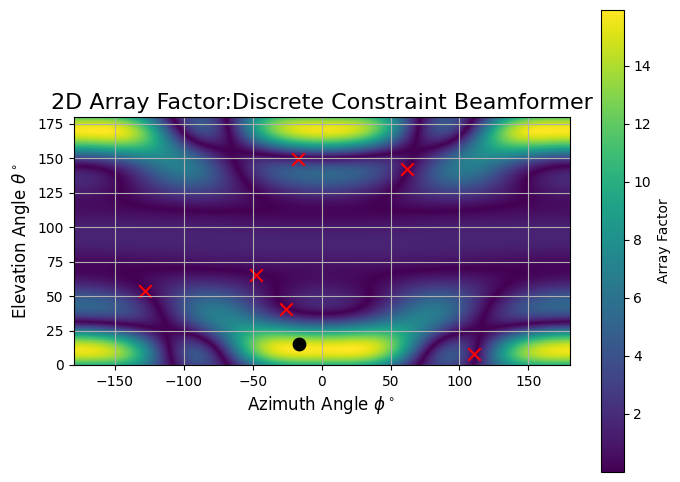

In [10]:
plt.figure(figsize=(8, 6))
im1 = plt.imshow(AF_PBBF,
                 extent=(AZ_MIN, AZ_MAX, EL_MIN, EL_MAX),
                 vmin=np.min(AF_PBBF),
                 vmax=np.max(AF_PBBF),
                 cmap='viridis',
                 origin='lower')

soi_indices = np.where(RESP_VEC != 0)[0]
interferer_indices = np.where(RESP_VEC == 0)[0]

# Plot interferers (nulls) - red 'x'
plt.scatter(AOA_AZ_VEC[interferer_indices], AOA_EL_VEC[interferer_indices],
            color='red', label='Interferer (Null)', marker='x',s=80)

# Plot source of interest (SoI) - blue 'o'
plt.scatter(AOA_AZ_VEC[soi_indices], AOA_EL_VEC[soi_indices],color ='black',
            label='Source of Interest', marker='o',s=80)

plt.colorbar(im1, label='Array Factor')
plt.title('2D Array Factor:Discrete Constraint Beamformer', size =16)
plt.xlabel(r'Azimuth Angle $\phi^\circ$', size=12)
plt.ylabel(r'Elevation Angle $\theta ^\circ$', size =12)
plt.grid()

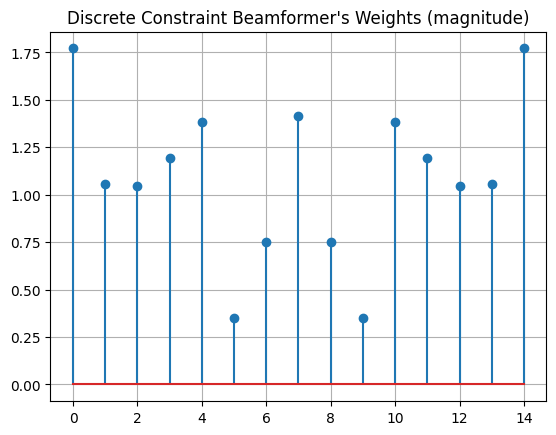

In [9]:
plt.figure()
plt.title("Discrete Constraint Beamformer's Weights (magnitude)")
plt.stem(np.abs(PB_BF_WEIGHTS))
plt.grid()
plt.show()